In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# 定义L2范数惩罚项
def l2_penalty(w, m):
    return (w**2).sum()/m/2

In [3]:
# 手动实现relu函数
def fun_relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

In [4]:
mnist_train = torchvision.datasets.FashionMNIST(root='..\Datasets\FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='..Datasets\FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# 小批量读取数据
batch_size = 64
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers=0)

In [6]:
# 手动实现前馈神经网络
# 定义模型参数
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [7]:
# 定义交叉熵损失函数
loss = torch.nn.CrossEntropyLoss()

In [8]:
# 定义模型
def net(X):
    X = X.view((-1, num_inputs))
    H = fun_relu(torch.matmul(X, W1.t()) + b1)
#     print('H.shape 展平', H.shape)
#     print('H 展平', H)
    return torch.matmul(H, W2.t()) + b2

In [9]:
# 定义随机梯度下降函数
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

In [10]:
# 计算准确率和loss
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X), y) + lamda * (l2_penalty(W1, y.shape[0]) + l2_penalty(W2, y.shape[0]))
            
        test_l_sum += l.item()
        n += y.shape[0]
    return acc_sum / n, test_l_sum / n

In [11]:
# 定义模型训练参数
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None, lamda=None):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        train_acc_sum, train_l_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y) + lamda * (l2_penalty(W1, y.shape[0]) + l2_penalty(W2, y.shape[0]))
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
                
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
       
        print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_l_sum / n, test_l))
    return train_loss, test_loss

epoch 1, train_loss 0.0107, test_loss 0.0089
epoch 2, train_loss 0.0071, test_loss 0.0075
epoch 3, train_loss 0.0064, test_loss 0.0067
epoch 4, train_loss 0.0060, test_loss 0.0067
epoch 5, train_loss 0.0057, test_loss 0.0062
epoch 6, train_loss 0.0055, test_loss 0.0063
epoch 7, train_loss 0.0053, test_loss 0.0062
epoch 8, train_loss 0.0052, test_loss 0.0059
epoch 9, train_loss 0.0050, test_loss 0.0060
epoch 10, train_loss 0.0049, test_loss 0.0057


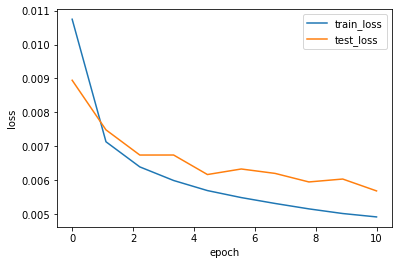

In [12]:
num_epochs = 10
lr = 0.1
lamda = 0.01
train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr, None, lamda)

#画图
x = np.linspace(0, len(train_loss), len(train_loss))
plt.plot(x, train_loss, label = 'train_loss', linewidth=1.5)
plt.plot(x, test_loss, label='test_loss', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()